# trace_retrace.ipynb
## Training ML Models Using Trace and Retrace Data

This notebook should succeed in improving the ML models we have tested in `benchmark.ipynb` and `simulator.ipynb` by adding both **trace and retrace** data to the dataset fed into the ML algorithms.

Some pickle files have been added to the repo in addition to this notebook. The pickle files contain this information (in addition to `.ibw` filedata):
- __traces:__ shape of (N, M, C, L), forward and backward scan lines for the "Height", "Amplitude", "Phase", and "ZHeight" channels.
- __x_measured:__ shape of (N, D), controlling parameters of "drive", "setpoint", and "I gain" for each set of the traces. Both drive and setpoint are in the unit of nanometers.
- __y_measured:__ shape of (N, P), recorded reward values in the optimization process.
- __param:__ important global parameters for the dataset, including ['ScanSize', 'ScanRate', 'PointsLines', 'IntegralGain', 'InvOLS', 'SpringConstant', 'DriveFrequency']
- __header:__ all the global parameters recorded in the topo.ibw file by the SPM controller
- __topo:__ topography with the optimized parameters for visualizing the area where the traces were taken

***Explanation of the shape values:***
- __N:__ number of different sets of controlling parameters. This value corresponding to the length of x_measured and y_measured. The first 5-10 are usually the random seeding points.
- __M:__ number of repeats for each set of controlling parameters. Usually this value is set to 5 to avoid random errors in the scan lines.
- __C:__ number of different channels recorded for the traces, usually set to 8
- __L:__ number of pixels in each trace line, usually set to be 256
- __D:__ number of controlling parameters, usually set to be 3
- __P:__ number of rewards. For BO, it's 1. For MOBO, it can be 3-4

It is important to note that this information was taken from another notebook. Though there is talk about rewards for training for reinforcement learning (RL) or Bayesian optimization (BO), **this notebook will solely focus on using the data from these pickle files to detect failures in the SPM image.**




In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import aespm as ae

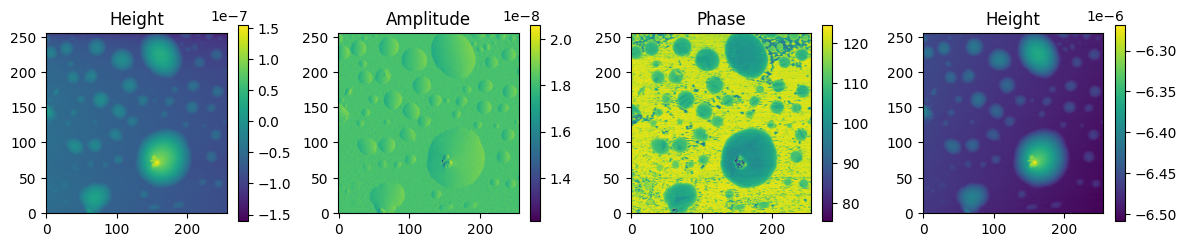

In [ ]:
sample_folder = os.path.join('scan_traces', 'MOBO')

files = os.listdir(sample_folder)

file_name = []
save_name = []

for f in files:
    if f.endswith('.pickle'):
        file_name.append(os.path.join(sample_folder, f))
        save_name.append(f.split('.')[0])

file_name = sorted(file_name)
file_name

with open(file_name[-7], 'rb') as fopen:
    obj = pickle.load(fopen)

topo = obj['topo']
titles = ['Height', 'Amplitude', 'Phase', 'Height']
fig, ax = plt.subplots(1,4,figsize=[12, 2.5])
for i in range(4):
    # If there are only 4 data channels in the topo.data, we don't need to skip any index
    im = ax[i].imshow(topo.data[::2][i], origin='lower')
    ax[i].set_title(titles[i])
    plt.colorbar(im, ax=ax[i])

plt.tight_layout()

(60, 5, 8, 256)


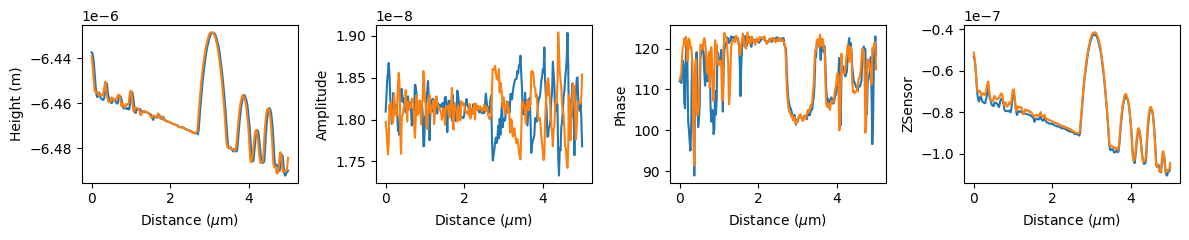

In [10]:
traces = obj['traces']
print(traces.data.shape)
np.shape(traces)

x = np.linspace(0, obj['param']['ScanSize']*1e6, np.shape(traces)[-1])

ylabels = ['Height (m)', 'Amplitude', 'Phase', 'ZSensor']
fig, ax = plt.subplots(1,4,figsize=[12, 2.5])
for i in range(4):
    ax[i].plot(x, traces[-1, -1, i*2], label='Fwd')
    ax[i].plot(x, traces[-1, -1, i*2+1], label='Bkd')
    ax[i].set_xlabel('Distance ($\mu$m)')
    ax[i].set_ylabel(ylabels[i])
    
plt.tight_layout()

# The forward scan is at the even index and the backward scan is at the odd index.

We now have a method to grab the trace and retrace information from these pickle files. So, to identify when there are errors in the SPM, we have several options.

Failures in the SPM typically arise from:
+ Non-overlapping trace/retrace curves in the Height, Phase, and ZSensor channels.
+ Distorted amplitude profiles.
+ Abnormally-high residuals between forward/backward paths.
+ Abrupt spikes or discontinuities in the lines.

So, similar to how we did for using the `.ibw` files, **we can use this data and some thresholds to create "good" and "bad" conditions.**

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trace_retrace(traces, scan_size_um, param_index=-1, repeat_index=-1, channel_names=None):
    """
    Plots forward (trace) and backward (retrace) scan lines for all channels.

    Parameters:
    - traces: np.ndarray, shape (N, M, C, L)
    - scan_size_um: float, total scan size in micrometers
    - param_index: int, index of which parameter set to show
    - repeat_index: int, index of which repeat to show
    - channel_names: list of str, optional names like ['Height', 'Amplitude', 'Phase', 'ZSensor']
    """
    if channel_names is None:
        channel_names = ['Channel {}'.format(i+1) for i in range(traces.shape[2] // 2)]

    x = np.linspace(0, scan_size_um, traces.shape[-1])
    n_channels = len(channel_names)

    fig, ax = plt.subplots(1, n_channels, figsize=(n_channels*4, 3))
    if n_channels == 1:
        ax = [ax]  # Make it iterable

    for i in range(n_channels):
        fwd = traces[param_index, repeat_index, i*2]
        bkd = traces[param_index, repeat_index, i*2 + 1]
        ax[i].plot(x, fwd, label='Trace', color='blue')
        ax[i].plot(x, bkd, label='Retrace', color='orange')
        ax[i].set_title(channel_names[i])
        ax[i].set_xlabel('Distance (μm)')
        ax[i].set_ylabel('Signal')
        ax[i].legend()

    plt.tight_layout()
    plt.show()

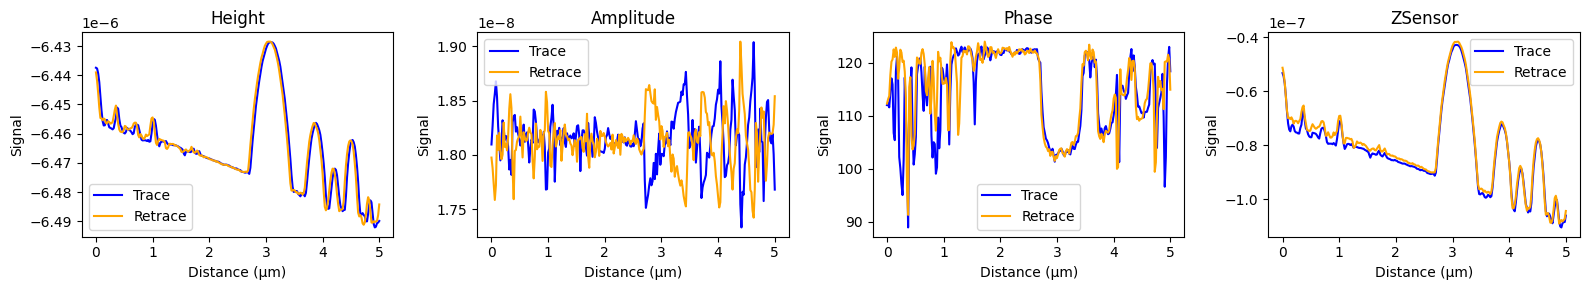

In [16]:
plot_trace_retrace(traces, scan_size_um=obj['param']['ScanSize']*1e6,
                   param_index=-1, repeat_index=-1,
                   channel_names=['Height', 'Amplitude', 'Phase', 'ZSensor'])

This allows us to plot the trace and retrace for visual identification of faults in the SPM. Next, we can use **mean absolute error (MAE) to see how different the trace/retraces are**.

In [17]:
def trace_retrace_score(traces, param_index, repeat_index, channel_names=None):
    """
    Returns simple similarity metrics for each channel.

    Returns a dict: {channel: {'mae': ..., 'corr': ...}, ...}
    """
    if channel_names is None:
        channel_names = ['Channel {}'.format(i+1) for i in range(traces.shape[2] // 2)]

    results = {}
    for i, name in enumerate(channel_names):
        fwd = traces[param_index, repeat_index, i*2]
        bkd = traces[param_index, repeat_index, i*2 + 1]

        mae = np.mean(np.abs(fwd - bkd))
        corr = np.corrcoef(fwd, bkd)[0, 1]

        results[name] = {'mae': mae, 'corr': corr}

    return results

In [18]:
trace_retrace_score(traces, param_index=-1, repeat_index=-1,
                    channel_names=['Height', 'Amplitude', 'Phase', 'ZSensor'])

{'Height': {'mae': np.float64(2.394587639287238e-09),
  'corr': np.float64(0.969860344277649)},
 'Amplitude': {'mae': np.float64(3.164682335632385e-10),
  'corr': np.float64(-0.8588460308973723)},
 'Phase': {'mae': np.float64(3.1953956186771393),
  'corr': np.float64(0.715178625557531)},
 'ZSensor': {'mae': np.float64(1.6094758581441937e-09),
  'corr': np.float64(0.9970957623678702)}}


=== File 1: 240508_TONP_test2_.pickle ===
Height     | MAE: 7.332e-10 | Corr: +0.941
Amplitude  | MAE: 4.159e-11 | Corr: -0.712
Phase      | MAE: 4.309e+00 | Corr: +0.677
ZSensor    | MAE: 5.370e-10 | Corr: +0.975


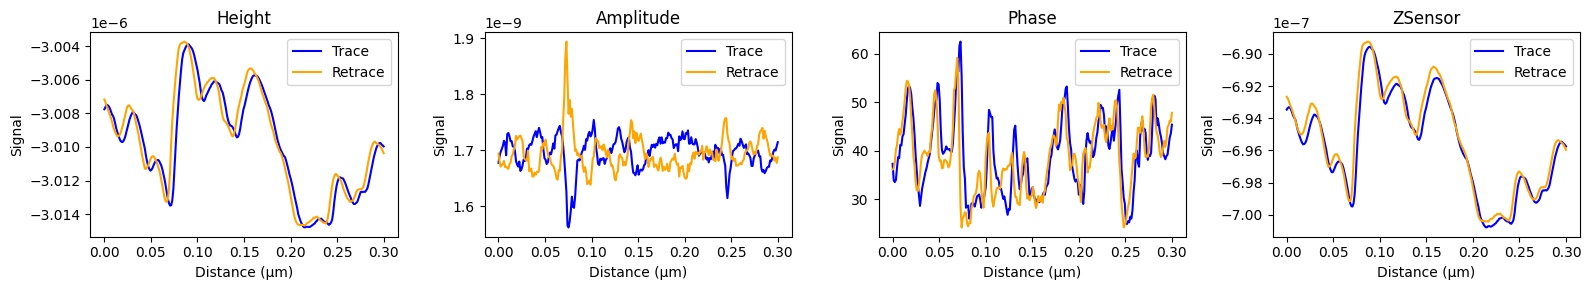


=== File 2: 2405612_Droplet_3D_.pickle ===
Height     | MAE: 2.243e-09 | Corr: +0.941
Amplitude  | MAE: 7.647e-11 | Corr: -0.492
Phase      | MAE: 1.896e+00 | Corr: +0.674
ZSensor    | MAE: 1.636e-09 | Corr: +0.988


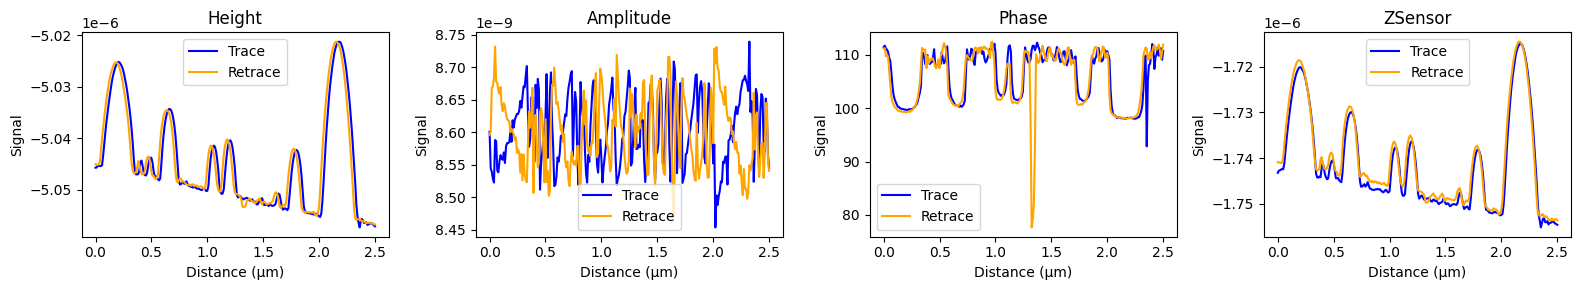


=== File 3: 2405612_Droplet_3D_2_.pickle ===
Height     | MAE: 6.183e-10 | Corr: +0.974
Amplitude  | MAE: 4.914e-11 | Corr: +0.269
Phase      | MAE: 4.518e+00 | Corr: +0.529
ZSensor    | MAE: 7.801e-10 | Corr: +0.979


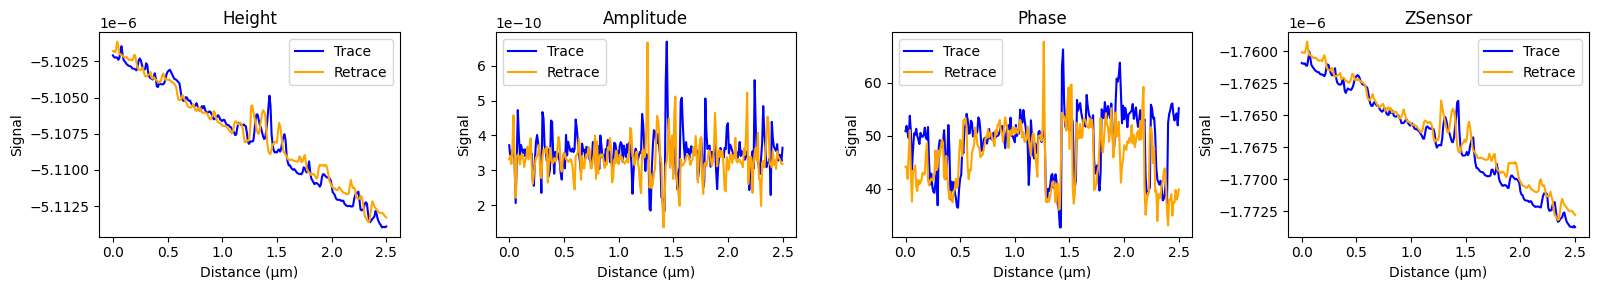


=== File 4: 240612_Droplet_test1_.pickle ===
Height     | MAE: 3.067e-09 | Corr: +0.905
Amplitude  | MAE: 7.752e-11 | Corr: -0.828
Phase      | MAE: 8.558e-01 | Corr: +0.655
ZSensor    | MAE: 2.331e-09 | Corr: +0.974


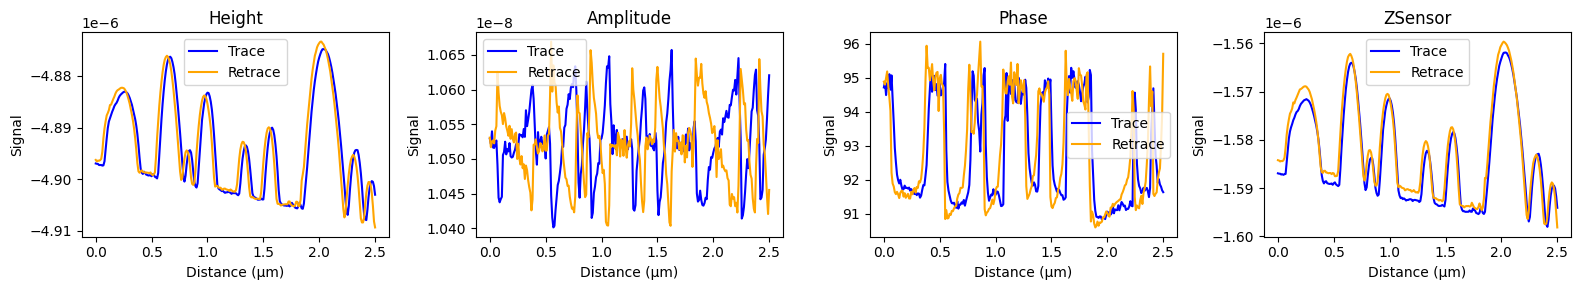


=== File 5: 240619_Droplet_test1_.pickle ===
Height     | MAE: 1.471e-09 | Corr: +0.939
Amplitude  | MAE: 1.021e-10 | Corr: -0.526
Phase      | MAE: 1.524e+00 | Corr: +0.612
ZSensor    | MAE: 1.983e-09 | Corr: +0.978


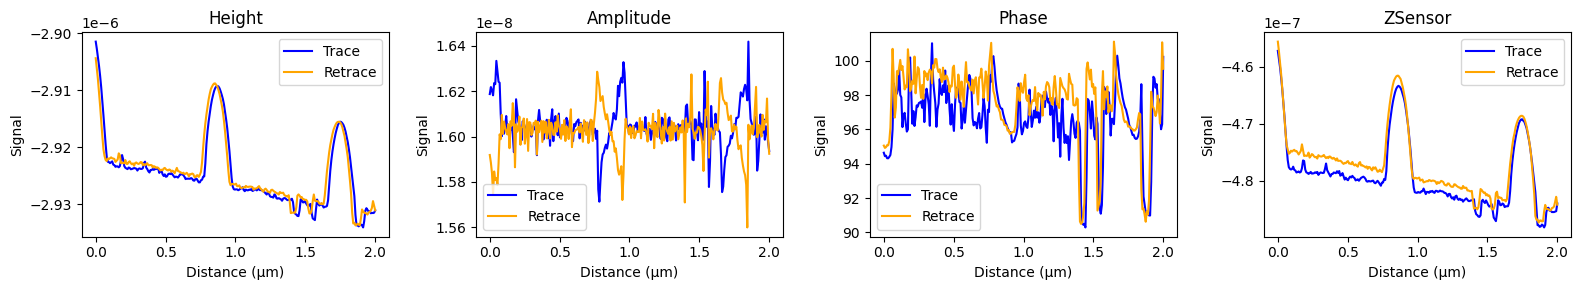


=== File 6: 240619_Droplet_test2_.pickle ===
Height     | MAE: 1.079e-09 | Corr: +0.950
Amplitude  | MAE: 1.640e-10 | Corr: -0.199
Phase      | MAE: 2.009e+00 | Corr: +0.925
ZSensor    | MAE: 1.591e-09 | Corr: +0.985


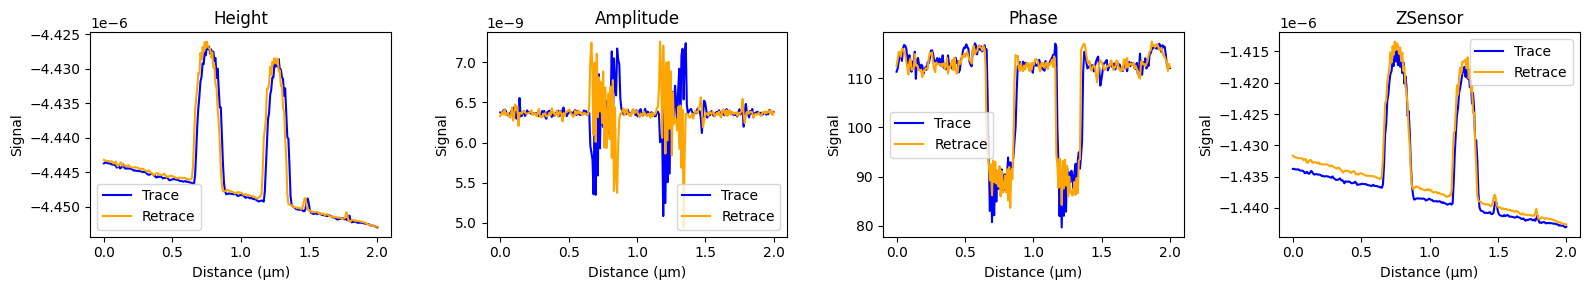


=== File 7: 240619_Droplet_test3_.pickle ===
Height     | MAE: 5.183e-09 | Corr: +0.445
Amplitude  | MAE: 1.621e-10 | Corr: -0.276
Phase      | MAE: 1.065e+01 | Corr: +0.202
ZSensor    | MAE: 5.315e-09 | Corr: +0.522


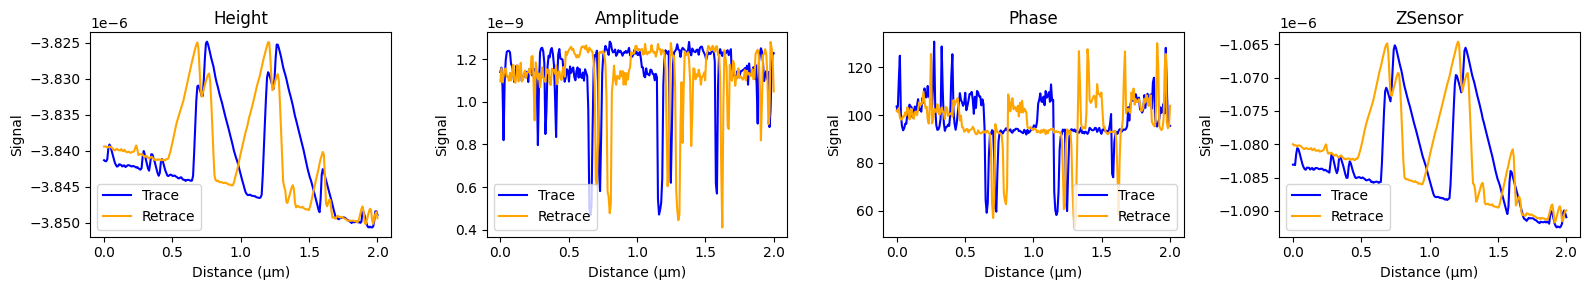


=== File 8: 240619_Droplet_test4_.pickle ===
Height     | MAE: 5.030e-10 | Corr: +0.953
Amplitude  | MAE: 3.832e-11 | Corr: -0.686
Phase      | MAE: 7.826e-01 | Corr: +0.818
ZSensor    | MAE: 1.372e-09 | Corr: +0.985


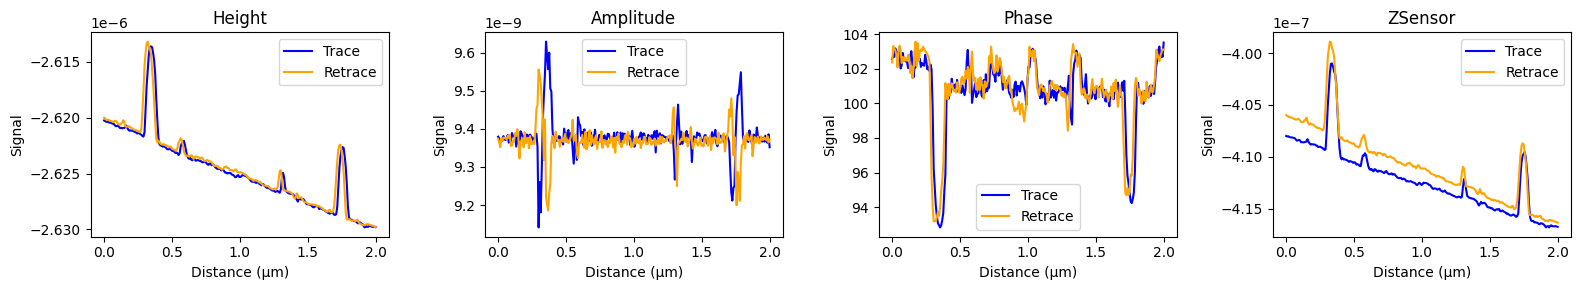


=== File 9: 240619_Droplet_test5_.pickle ===
Height     | MAE: 2.903e-10 | Corr: +0.989
Amplitude  | MAE: 1.972e-11 | Corr: -0.226
Phase      | MAE: 2.310e+00 | Corr: +0.902
ZSensor    | MAE: 1.115e-09 | Corr: +0.993


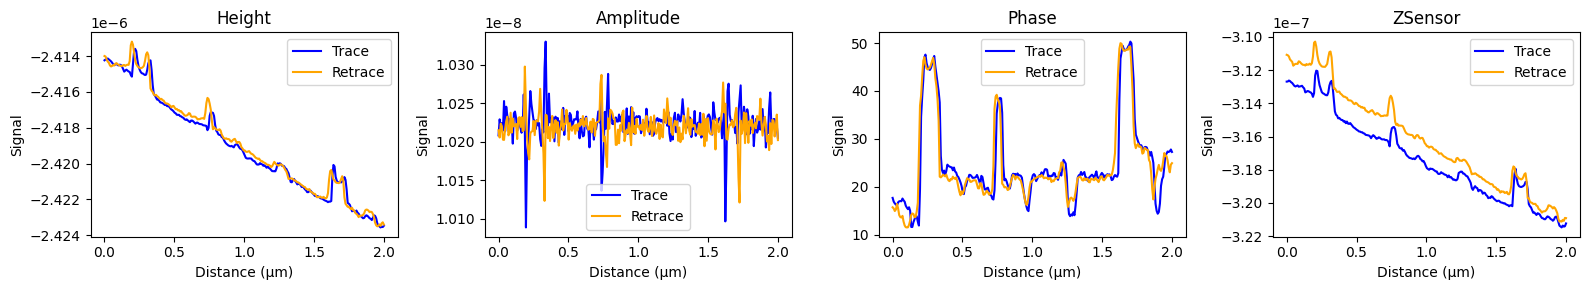


=== File 10: 240619_Droplet_test6_.pickle ===
Height     | MAE: 4.999e-10 | Corr: +0.963
Amplitude  | MAE: 3.585e-11 | Corr: -0.017
Phase      | MAE: 7.953e-01 | Corr: +0.959
ZSensor    | MAE: 5.602e-10 | Corr: +0.989


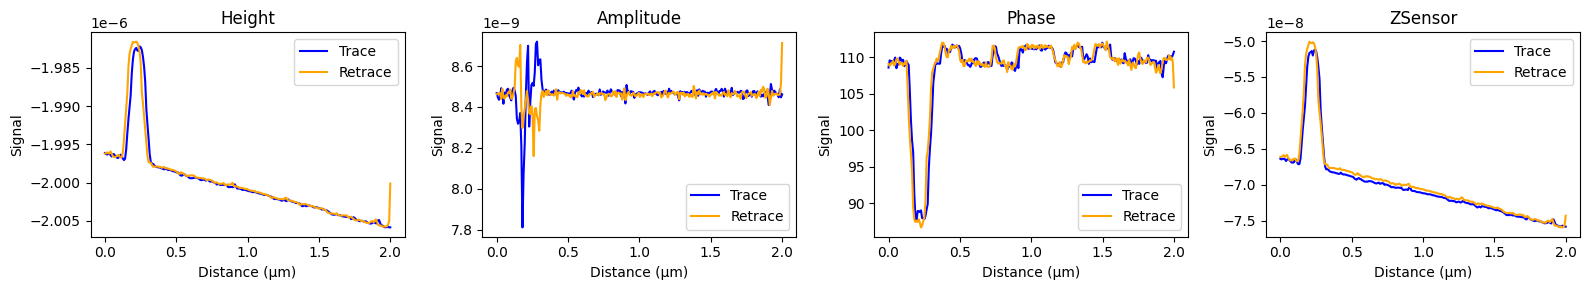


=== File 11: 240627_Droplet_test1_.pickle ===
Height     | MAE: 1.732e-09 | Corr: +0.998
Amplitude  | MAE: 1.997e-10 | Corr: -0.010
Phase      | MAE: 2.478e+00 | Corr: +0.913
ZSensor    | MAE: 2.973e-09 | Corr: +0.998


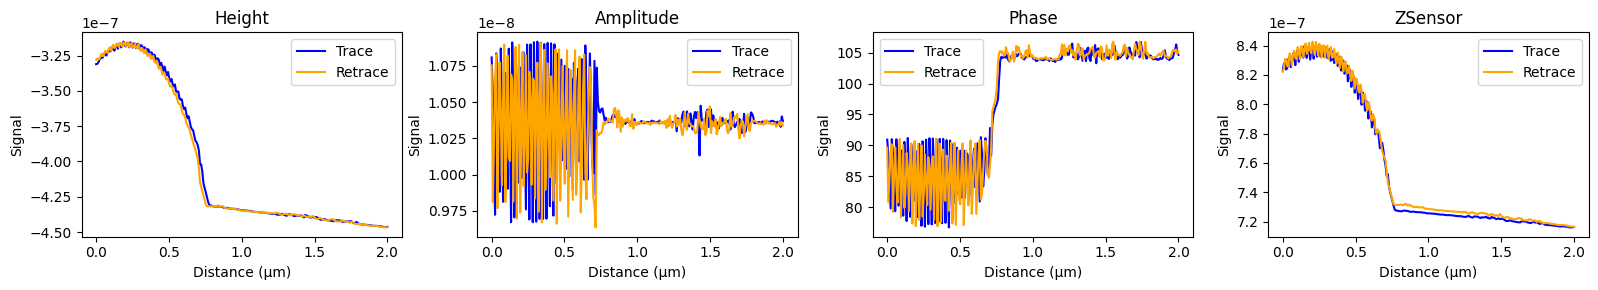


=== File 12: 240627_Droplet_test2_.pickle ===
Height     | MAE: 1.425e-09 | Corr: +0.974
Amplitude  | MAE: 8.341e-11 | Corr: -0.016
Phase      | MAE: 2.484e+00 | Corr: +0.980
ZSensor    | MAE: 1.442e-09 | Corr: +0.993


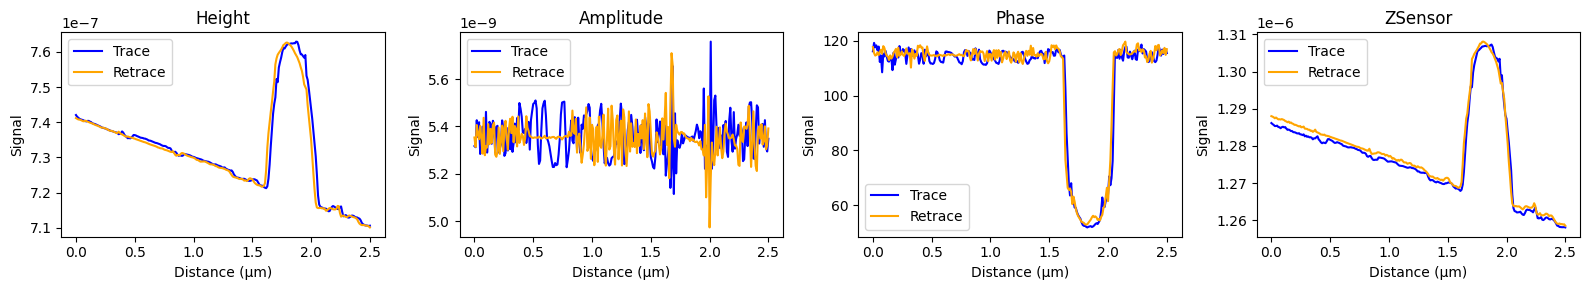


=== File 13: 240627_Droplet_test3_.pickle ===
Height     | MAE: 1.677e-09 | Corr: +0.982
Amplitude  | MAE: 5.696e-11 | Corr: -0.720
Phase      | MAE: 1.783e-01 | Corr: +0.901
ZSensor    | MAE: 1.603e-09 | Corr: +0.998


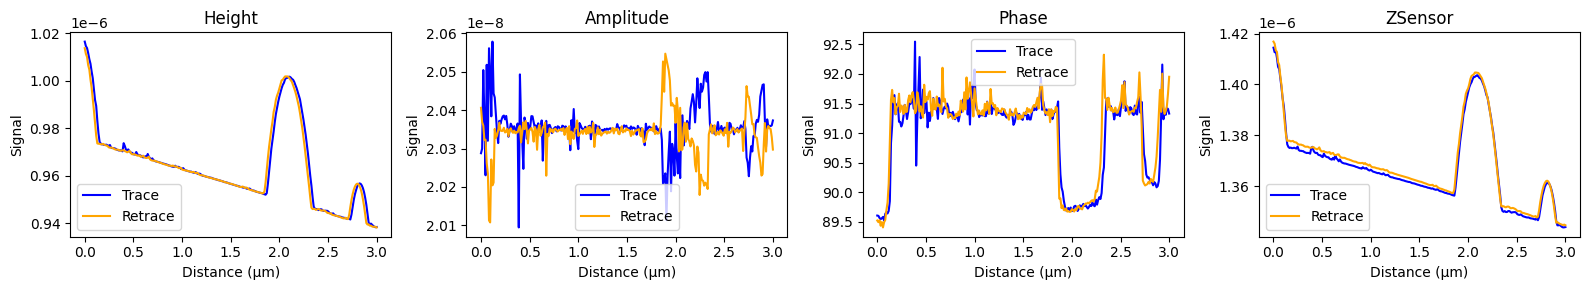


=== File 14: 240627_Droplet_test4_.pickle ===
Height     | MAE: 2.048e-09 | Corr: +0.978
Amplitude  | MAE: 6.012e-11 | Corr: -0.670
Phase      | MAE: 2.246e-01 | Corr: +0.917
ZSensor    | MAE: 1.367e-09 | Corr: +0.996


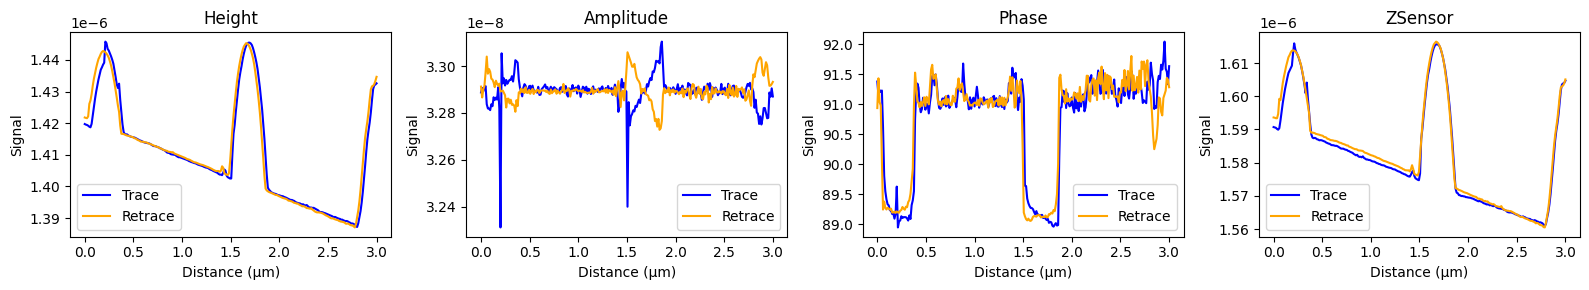


=== File 15: 240627_Droplet_test5_.pickle ===
Height     | MAE: 1.470e-09 | Corr: +0.981
Amplitude  | MAE: 9.800e-11 | Corr: -0.365
Phase      | MAE: 6.243e+00 | Corr: +0.882
ZSensor    | MAE: 2.542e-09 | Corr: +0.992


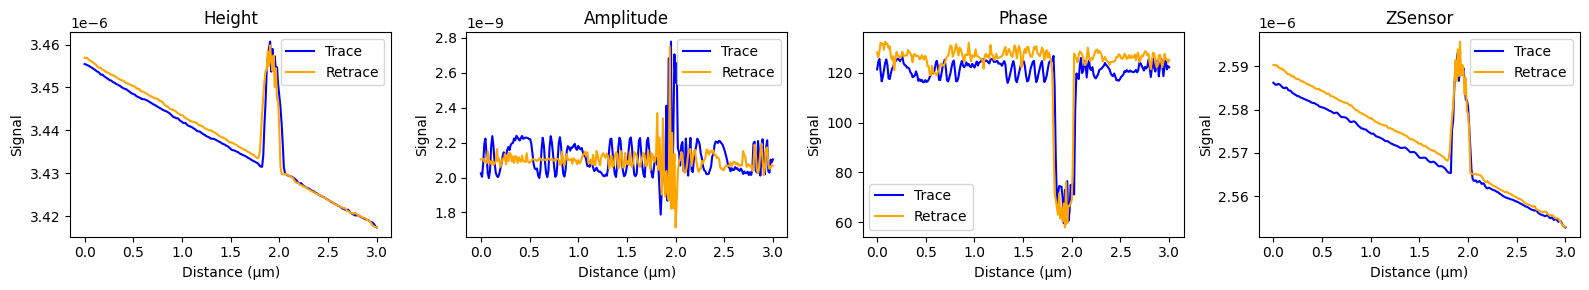


=== File 16: 240627_Droplet_test6_.pickle ===
Height     | MAE: 6.796e-10 | Corr: +0.990
Amplitude  | MAE: 2.400e-11 | Corr: -0.905
Phase      | MAE: 1.446e+00 | Corr: +0.953
ZSensor    | MAE: 1.220e-09 | Corr: +0.999


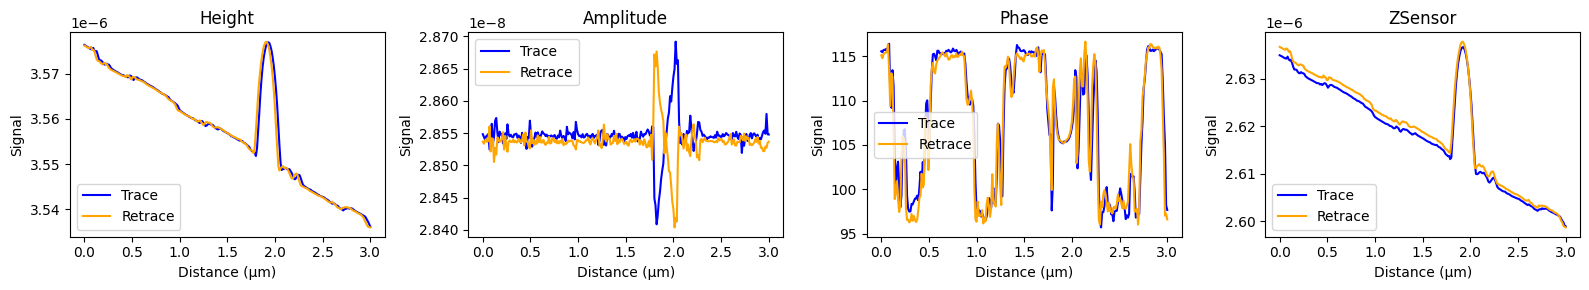


=== File 17: 240627_Droplet_test7_.pickle ===
Height     | MAE: 1.890e-09 | Corr: +0.967
Amplitude  | MAE: 1.614e-10 | Corr: -0.605
Phase      | MAE: 2.939e+00 | Corr: +0.911
ZSensor    | MAE: 1.792e-09 | Corr: +0.983


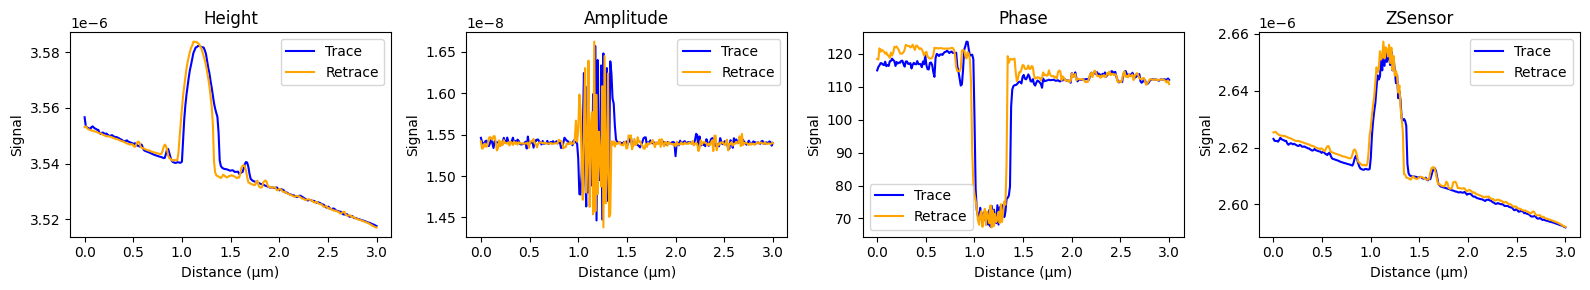


=== File 18: 240627_grating_test1_.pickle ===
Height     | MAE: 7.074e-09 | Corr: +0.944
Amplitude  | MAE: 4.641e-10 | Corr: -0.658
Phase      | MAE: 1.586e+00 | Corr: -0.384
ZSensor    | MAE: 4.860e-09 | Corr: +0.994


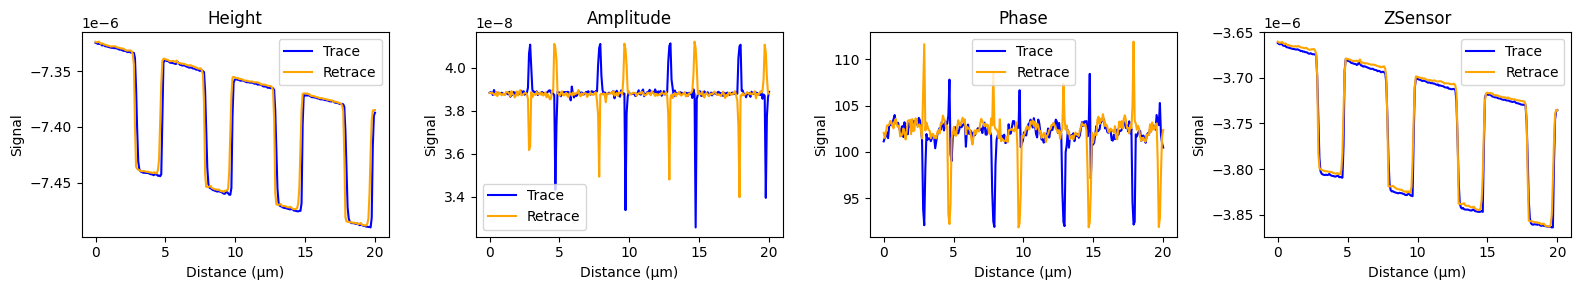


=== File 19: 240627_grating_test2_.pickle ===
Height     | MAE: 3.819e-09 | Corr: +0.980
Amplitude  | MAE: 4.361e-10 | Corr: -0.626
Phase      | MAE: 1.103e+00 | Corr: +0.574
ZSensor    | MAE: 4.322e-09 | Corr: +0.993


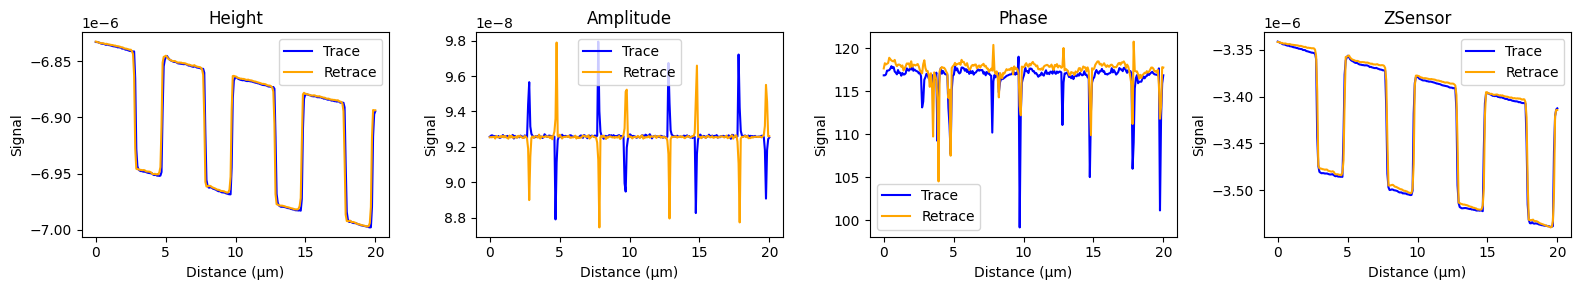


=== File 20: 240627_grating_test3_.pickle ===
Height     | MAE: 3.965e-09 | Corr: +0.981
Amplitude  | MAE: 4.488e-10 | Corr: -0.602
Phase      | MAE: 1.167e+00 | Corr: +0.193
ZSensor    | MAE: 4.991e-09 | Corr: +0.990


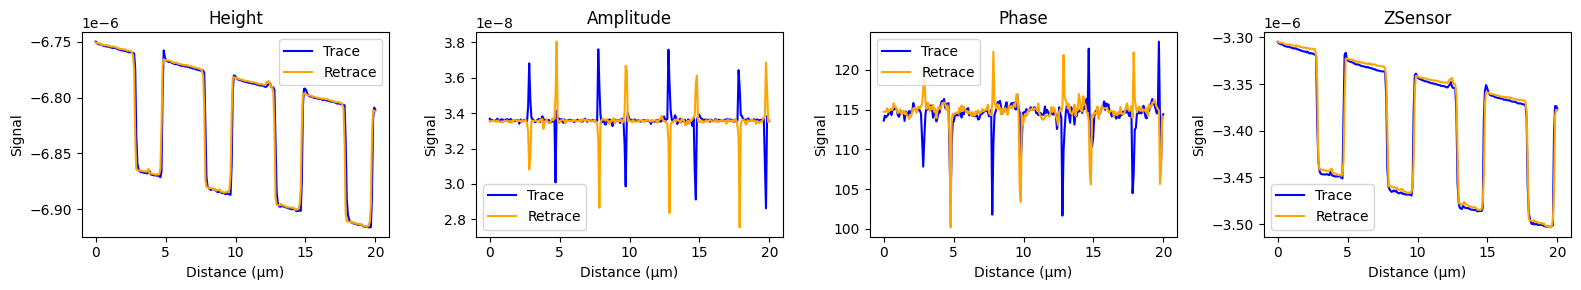


=== File 21: 240717_CBI_R2_.pickle ===
Height     | MAE: 4.367e-08 | Corr: +0.997
Amplitude  | MAE: 9.650e-10 | Corr: -0.621
Phase      | MAE: 5.629e+00 | Corr: +0.703
ZSensor    | MAE: 7.436e-08 | Corr: +0.996


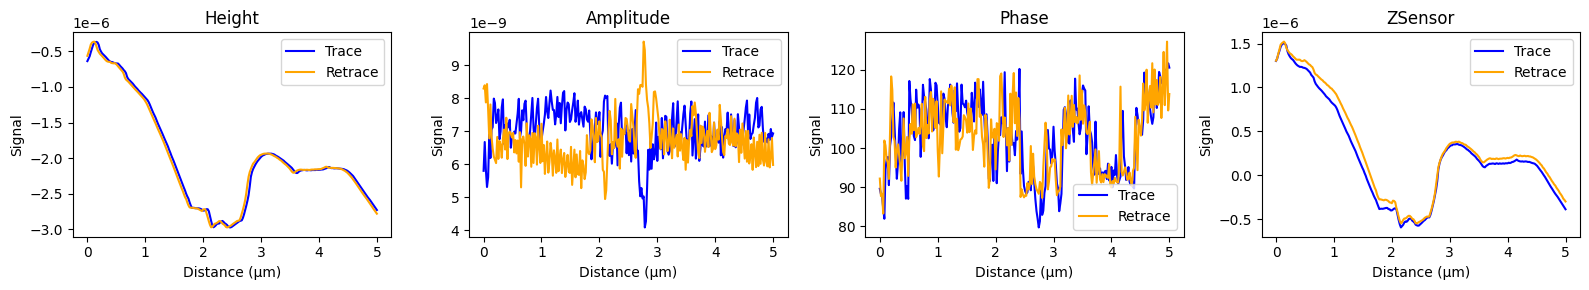


=== File 22: 240717_CBI_R2_test2.pickle ===
Height     | MAE: 4.406e-08 | Corr: +0.975
Amplitude  | MAE: 1.079e-09 | Corr: -0.731
Phase      | MAE: 6.979e+00 | Corr: +0.432
ZSensor    | MAE: 2.067e-08 | Corr: +0.995


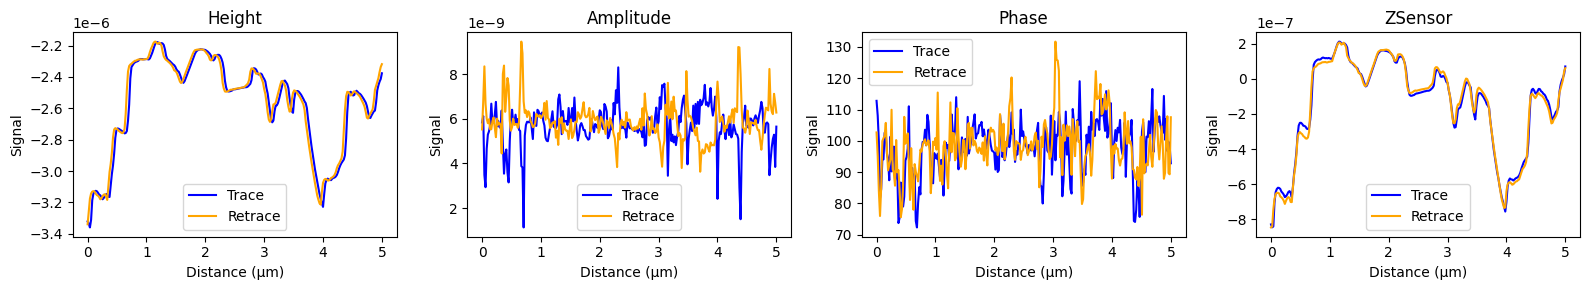


=== File 23: 240717_Droplet_R2_test1.pickle ===
Height     | MAE: 5.444e-09 | Corr: +0.974
Amplitude  | MAE: 6.691e-10 | Corr: -0.519
Phase      | MAE: 1.013e+01 | Corr: +0.899
ZSensor    | MAE: 3.224e-09 | Corr: +0.992


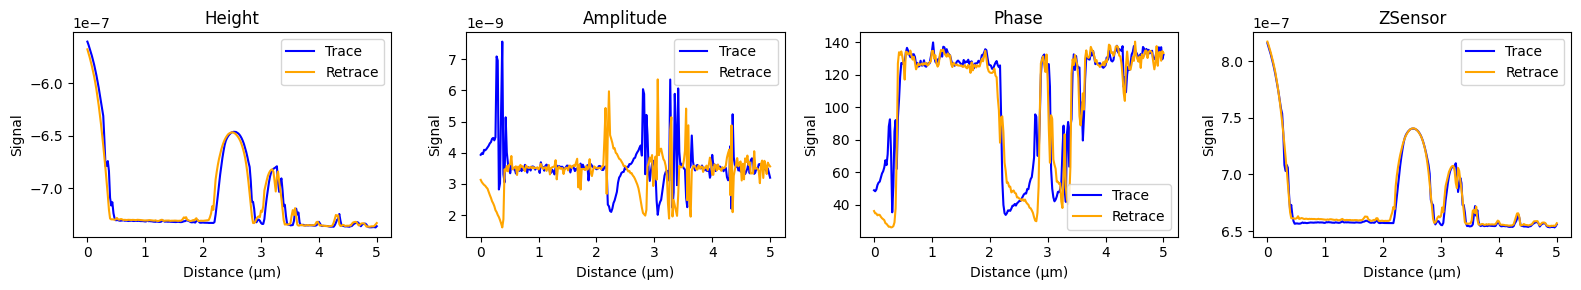


=== File 24: 240717_Droplet_R2_test3.pickle ===
Height     | MAE: 7.135e-09 | Corr: +0.994
Amplitude  | MAE: 2.612e-09 | Corr: -0.280
Phase      | MAE: 7.933e+00 | Corr: +0.927
ZSensor    | MAE: 7.319e-09 | Corr: +0.993


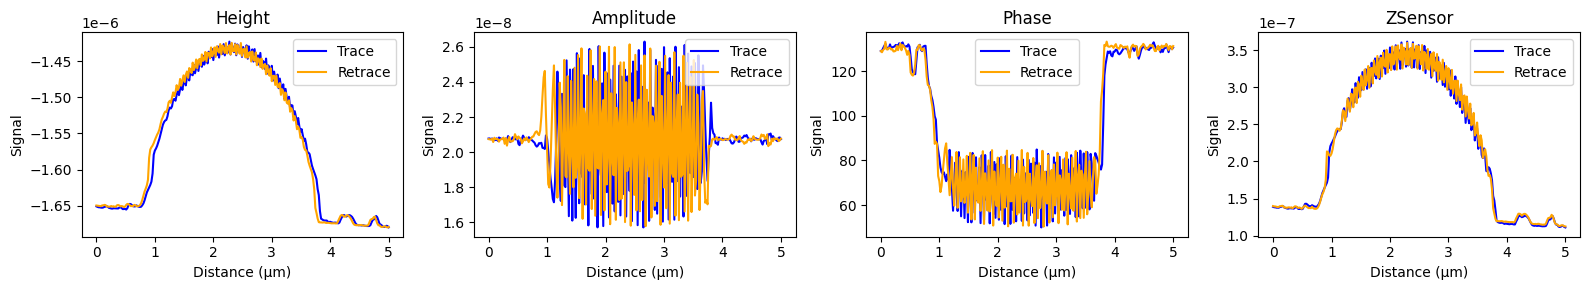

In [ ]:
import os
import pickle
import numpy as np
from scipy.stats import pearsonr

# Set the folder path
sample_folder = os.path.join('scan_traces', 'MOBO')

# Get list of all .pickle files
files = sorted([
    os.path.join(sample_folder, f) for f in os.listdir(sample_folder)
    if f.endswith('.pickle')
])

# Helper function: Compute MAE and correlation between forward and backward traces
def compute_trace_metrics(trace_data):
    results = {}
    channel_names = ['Height', 'Amplitude', 'Phase', 'ZSensor']
    
    for i, name in enumerate(channel_names):
        fwd = trace_data[i * 2]
        bwd = trace_data[i * 2 + 1]
        
        mae = np.mean(np.abs(fwd - bwd))
        try:
            corr, _ = pearsonr(fwd, bwd)
        except:
            corr = np.nan
        
        results[name] = {'mae': mae, 'corr': corr}
    
    return results

# Loop through each file
for idx, fname in enumerate(files):
    with open(fname, 'rb') as fopen:
        obj = pickle.load(fopen)
    
    print(f"\n=== File {idx+1}: {os.path.basename(fname)} ===")
    
    traces = obj['traces']
    
    # Use the last scan: shape (N, M, C, L)
    trace_sample = traces[-1, -1]  # Shape (8, L), assumes 4 channels with forward/backward pairs
    
    metrics = compute_trace_metrics(trace_sample)
    
    for ch in metrics:
        mae = metrics[ch]['mae']
        corr = metrics[ch]['corr']
        print(f"{ch:10s} | MAE: {mae:.3e} | Corr: {corr:+.3f}")

    plot_trace_retrace(traces, scan_size_um=obj['param']['ScanSize']*1e6,
                   param_index=-1, repeat_index=-1,
                   channel_names=['Height', 'Amplitude', 'Phase', 'ZSensor'])